<a href="https://colab.research.google.com/github/bislara/Conditional-Gan-using-PyTorch/blob/master/cGAN_using_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!mkdir .kaggle

In [0]:
import json

token = {"username":"biswajeetsahoo54","key":"1ce5cac341a71f094959287c3a210236"}
with open('/content/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)

In [0]:
!cp /content/.kaggle/kaggle.json  /root/.kaggle/kaggle.json

In [0]:
!kaggle datasets list

ref                                                         title                                                size  lastUpdated          downloadCount  
----------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  
unanimad/dataisbeautiful                                    Reddit - Data is Beautiful                           11MB  2020-03-21 22:28:28            807  
allen-institute-for-ai/CORD-19-research-challenge           COVID-19 Open Research Dataset Challenge (CORD-19)  646MB  2020-03-20 23:31:34          28950  
rubenssjr/brasilian-houses-to-rent                          brazilian_houses_to_rent                            117KB  2020-03-15 01:12:22            757  
sudalairajkumar/novel-corona-virus-2019-dataset             Novel Corona Virus 2019 Dataset                     412KB  2020-03-24 06:10:13          79720  
kimjihoo/coronavirusdataset                                 Data

In [0]:
!kaggle datasets download -d zalando-research/fashionmnist

 71% 49.0M/68.8M [00:01<00:00, 20.7MB/s]
100% 68.8M/68.8M [00:01<00:00, 36.6MB/s]


In [0]:
!unzip \*.zip

Archive:  fashionmnist.zip
  inflating: fashion-mnist_test.csv  
  inflating: fashion-mnist_train.csv  
  inflating: t10k-images-idx3-ubyte  
  inflating: t10k-labels-idx1-ubyte  
  inflating: train-images-idx3-ubyte  
  inflating: train-labels-idx1-ubyte  


In [0]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torch import autograd
from torch.autograd import Variable
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

In [0]:
class FashionMNIST(Dataset):
    def __init__(self, transform=None):
        self.transform = transform
        fashion_df = pd.read_csv('fashion-mnist_train.csv')
        self.labels = fashion_df.label.values
        self.images = fashion_df.iloc[:, 1:].values.astype('uint8').reshape(-1, 28, 28)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        label = self.labels[idx]
        img = Image.fromarray(self.images[idx])
        
        if self.transform:
            img = self.transform(img)

        return img, label

In [0]:
dataset = FashionMNIST()
# from PIL import Image 
# from google.colab.patches import cv2_imshow
# # img = Image.open(dataset[0][0])
# # img.show()
# img = dataset[0][0].save(fp="test",format="PNG")
print(dataset)
print(len(dataset))
print((dataset[1][0].size))
dataset[1][0]

60000
(28, 28)


In [0]:
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5,), std=(0.5,))
])
dataset = FashionMNIST(transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=4, shuffle=True)

In [0]:
print(dataloader)
print(len(dataloader))

15000


In [0]:
# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

In [0]:
# Plot some training images
import torchvision.utils as vutils
classes=['T-Shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
print(classes)

['T-Shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


torch.Size([4, 1, 28, 28])


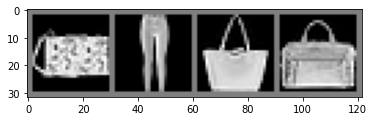

  Bag Trouser   Bag   Bag


In [0]:
import torchvision

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get rand image
dataiter = iter(dataloader)
images, labels = dataiter.next()

print(images.size())
# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [0]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator,self).__init__()
        
        self.label_emb = nn.Embedding(10, 10)
        
        self.model = nn.Sequential(
            nn.Linear(794, 1024),   #794 after adding 10 columns of labels in the array
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x, labels):
        x = x.view(x.size(0), 784)  # 28*28=784 Image is of size 28*28
        c = self.label_emb(labels)
        x = torch.cat([x, c], 1)
        out = self.model(x)
        return out.squeeze()

In [0]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.label_emb = nn.Embedding(10, 10)
        
        self.model = nn.Sequential(
            nn.Linear(110, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 784),
            nn.Tanh()
        )
    
    def forward(self, z, labels):
        z = z.view(z.size(0), 100)
        c = self.label_emb(labels)
        x = torch.cat([z, c], 1)
        out = self.model(x)
        return out.view(x.size(0), 28, 28)

In [0]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)
print(generator)
print(discriminator)

Generator(
  (label_emb): Embedding(10, 10)
  (model): Sequential(
    (0): Linear(in_features=110, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Linear(in_features=512, out_features=1024, bias=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Linear(in_features=1024, out_features=784, bias=True)
    (7): Tanh()
  )
)
Discriminator(
  (label_emb): Embedding(10, 10)
  (model): Sequential(
    (0): Linear(in_features=794, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8

In [0]:
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=1e-4)
g_optimizer = torch.optim.Adam(generator.parameters(), lr=1e-4)

In [0]:
def generator_train_step(batch_size, discriminator, generator, g_optimizer, criterion):
    g_optimizer.zero_grad()
    z = Variable(torch.randn(batch_size, 100)).to(device)
    fake_labels = Variable(torch.LongTensor(np.random.randint(0, 10, batch_size))).to(device)
    fake_images = generator(z, fake_labels)
    validity = discriminator(fake_images, fake_labels)
    g_loss = criterion(validity, Variable(torch.ones(batch_size)).to(device))
    g_loss.backward()
    g_optimizer.step()
    return g_loss.data

In [0]:
def discriminator_train_step(batch_size, discriminator, generator, d_optimizer, criterion, real_images, labels):
    d_optimizer.zero_grad()

    # train with real images
    real_validity = discriminator(real_images, labels)
    real_loss = criterion(real_validity, Variable(torch.ones(batch_size)).to(device))
    
    # train with fake images
    z = Variable(torch.randn(batch_size, 100)).to(device)
    fake_labels = Variable(torch.LongTensor(np.random.randint(0, 10, batch_size))).to(device)
    fake_images = generator(z, fake_labels)
    fake_validity = discriminator(fake_images, fake_labels)
    fake_loss = criterion(fake_validity, Variable(torch.zeros(batch_size)).to(device))
    
    d_loss = real_loss + fake_loss
    d_loss.backward()
    d_optimizer.step()
    return d_loss.data

In [0]:
# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

[4/5][14602/15000]	Loss_D: 1.4368	Loss_G: 0.9516
[4/5][14604/15000]	Loss_D: 1.4813	Loss_G: 0.7415
[4/5][14606/15000]	Loss_D: 1.2041	Loss_G: 1.0471
[4/5][14608/15000]	Loss_D: 1.1361	Loss_G: 0.8057
[4/5][14610/15000]	Loss_D: 1.5048	Loss_G: 0.8653
[4/5][14612/15000]	Loss_D: 1.1310	Loss_G: 0.7295
[4/5][14614/15000]	Loss_D: 1.1467	Loss_G: 0.8119
[4/5][14616/15000]	Loss_D: 1.2721	Loss_G: 0.9282
[4/5][14618/15000]	Loss_D: 1.3311	Loss_G: 0.8673
[4/5][14620/15000]	Loss_D: 1.2631	Loss_G: 0.8388
[4/5][14622/15000]	Loss_D: 1.0761	Loss_G: 0.8453
[4/5][14624/15000]	Loss_D: 1.1237	Loss_G: 0.8331
[4/5][14626/15000]	Loss_D: 1.3024	Loss_G: 0.7666
[4/5][14628/15000]	Loss_D: 1.3997	Loss_G: 0.6095
[4/5][14630/15000]	Loss_D: 1.5192	Loss_G: 0.6066
[4/5][14632/15000]	Loss_D: 1.4345	Loss_G: 0.8709
[4/5][14634/15000]	Loss_D: 0.9467	Loss_G: 0.7758
[4/5][14636/15000]	Loss_D: 1.2082	Loss_G: 0.8709
[4/5][14638/15000]	Loss_D: 1.1728	Loss_G: 0.7637
[4/5][14640/15000]	Loss_D: 1.3229	Loss_G: 0.8650
[4/5][14642/15000]	L

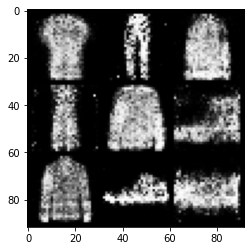

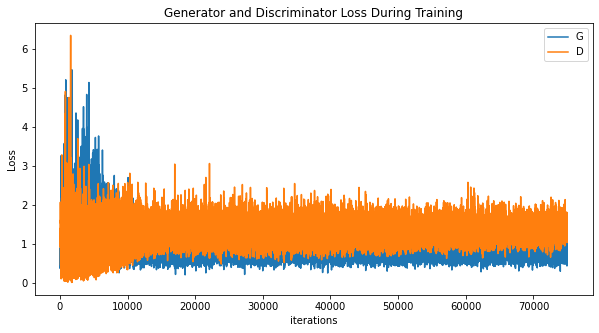

In [0]:
num_epochs = 5
n_critic = 5
display_step = 300
for epoch in range(num_epochs):
    print('Starting epoch {}...'.format(epoch))
    for i, (images, labels) in enumerate(dataloader):
        real_images = Variable(images).to(device)
        labels = Variable(labels).to(device)
        generator.train()
        batch_size = real_images.size(0)
        d_loss = discriminator_train_step(len(real_images), discriminator,generator, d_optimizer, criterion,real_images, labels)
        

        g_loss = generator_train_step(batch_size, discriminator, generator, g_optimizer, criterion)
        if i % 2 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f' % (epoch, num_epochs, i, len(dataloader),d_loss,g_loss))
        
        # Save Losses for plotting later
        G_losses.append(g_loss)
        D_losses.append(d_loss)
        


    generator.eval()
    print('g_loss: {}, d_loss: {}'.format(g_loss, d_loss))
    z = Variable(torch.randn(9, 100)).to(device)
    labels = Variable(torch.LongTensor(np.arange(9))).to(device)
    sample_images = generator(z, labels).unsqueeze(1).data.to(device)
    grid = make_grid(sample_images, nrow=3, normalize=True).permute(1,2,0).numpy()
    plt.imshow(grid)
    plt.show()


plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()


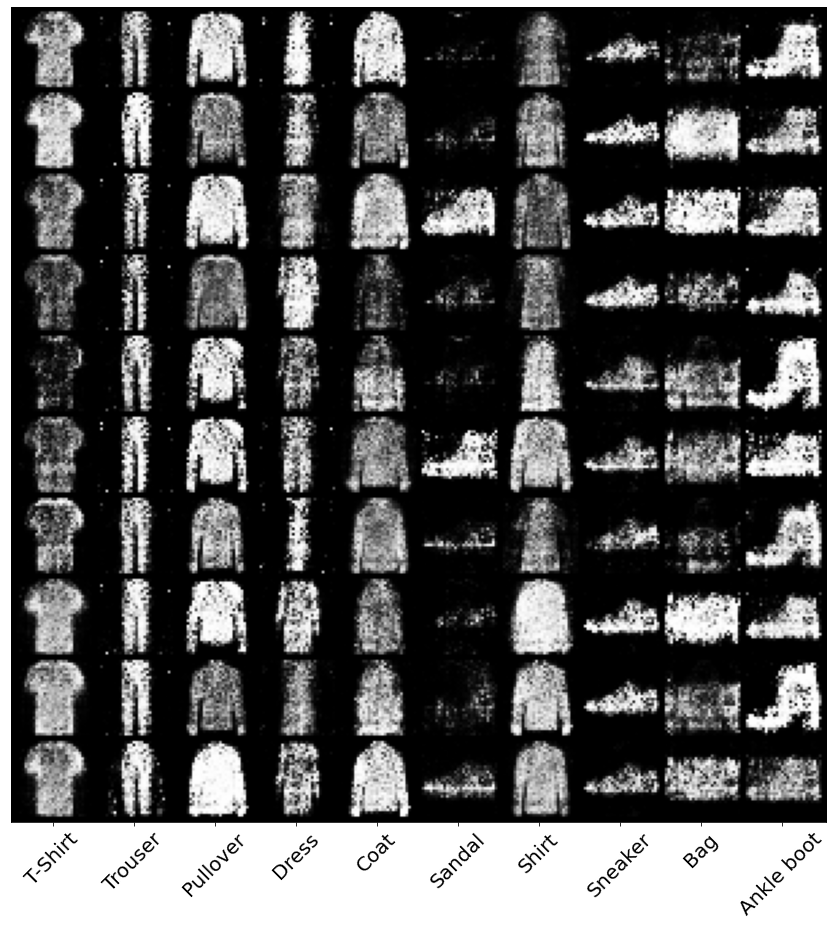

In [0]:
z = Variable(torch.randn(100, 100)).to(device)
labels = Variable(torch.LongTensor([i for _ in range(10) for i in range(10)])).to(device)
sample_images = generator(z, labels).unsqueeze(1).data.to(device)
grid = make_grid(sample_images, nrow=10, normalize=True).permute(1,2,0).numpy()
fig, ax = plt.subplots(figsize=(15,15))
ax.imshow(grid)
_ = plt.yticks([])
# _ = plt.xticks(np.arange(15, 300, 30), ['T-Shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'], rotation=45, fontsize=20)
_ = plt.xticks(np.arange(15, 300, 30), classes, rotation=45, fontsize=20)